In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import get_dataremodelled as gdr
import graphcreating as gc

### Data

In [2]:
df_en=pd.read_csv('Data/revisions_en.csv')
genderdf=pd.read_csv('gendered_titles_final.csv')
df_en=gdr.prep_data(df_en,genderdf)
df_en=gdr.prep_links(df_en,genderdf)

In [3]:
df_de=pd.read_csv('Data/revisions_de.csv')
df_fr=pd.read_csv('Data/revisions_fr.csv')
df_es=pd.read_csv('Data/revisions_es.csv')
df_de=gdr.prep_data(df_de,genderdf)
df_fr=gdr.prep_data(df_fr,genderdf)
df_es=gdr.prep_data(df_es,genderdf)
df_de=gdr.prep_links(df_de, genderdf)
df_fr=gdr.prep_links(df_fr, genderdf)
df_es=gdr.prep_links(df_es, genderdf)

In [4]:
text_and_community = pd.read_csv('text_and_community_infomap.csv')

text_and_community = text_and_community[['Community ID', 'Member Name']].drop_duplicates('Member Name')

In [5]:
text_and_community

,Community ID,Member Name
0,1,Niels Bohr
2,1,Max Born
3,1,Werner Heisenberg
4,1,Enrico Fermi
5,1,Edward Teller
...,...,...
19493,526,Winston W. Royce
19494,527,Akin Adesokan
19495,527,Yemisi Aribisala
19496,528,Edward W. Berry


In [6]:
merged_df = text_and_community.merge(df_en, left_on='Member Name', right_on='Name')

df_en = pd.DataFrame(merged_df)

### K core funciton

In [7]:
def k_core_func(df_lang, year,d):
    genderdf=pd.read_csv('gendered_titles_final.csv')
    df = df_lang[(df_lang['Year'] == year)]

    # Create graph
    G = nx.DiGraph()
    added_nodes = set()
    node_gender = {}
    for index, row in df.iterrows():
        source = row['Name']
        target = row['Link']
        status = row['added_or_removed']
        source_year=row['Year']
        source_gender = row['gender']
        target_gender = genderdf[genderdf['Name'] == target]['gender'].iloc[0] if not genderdf[genderdf['Name'] == target]['gender'].empty else None

        df_temp=df[df['Name']==target]
        targetlen=len(df_temp)
        df_temp=df[df['Name']==source]
        sourcelen=len(df_temp)

        if (status == 'added' or status == 'unchanged') and target!=source:
            G.add_node(source, gender=source_gender,year=source_year)
            node_gender[source] = source_gender
            if targetlen>0 or sourcelen>0:
                if target not in G:
                    G.add_node(target,gender=target_gender,year=source_year)
                    node_gender[target] = target_gender
                G.add_edge(source, target)    

    maletotal = []
    maleremoved = []    
    male_removal_ratios = []
    femaletotal = []
    femaleremoved = []
    female_removal_ratios = []
    female_percentage_remaining = []
    initial_number_of_nodes = G.number_of_nodes()

    def k_core_step(graph, step):
        total_males = sum(1 for node in graph.nodes if node_gender.get(node) == 'm')
        total_females = sum(1 for node in graph.nodes if node_gender.get(node) == 'f')
        degree_threshold = d

        high_degree_nodes = [node for node in graph.nodes if graph.degree(node) > degree_threshold]
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) <= degree_threshold]
        graph.remove_nodes_from(nodes_to_remove)
        subgraph = graph.subgraph(high_degree_nodes).copy()

        # Count removed male and female nodes
        maletotal.append(total_males)
        femaletotal.append(total_females)
         
        male_removed = sum(1 for node in nodes_to_remove if node_gender.get(node) == 'm')
        maleremoved.append(male_removed)
        female_removed = sum(1 for node in nodes_to_remove if node_gender.get(node) == 'f')
        femaleremoved.append(female_removed)
        male_ratio = male_removed / total_males if total_males > 0 else 0
        female_ratio = female_removed / total_females if total_females > 0 else 0
        male_removal_ratios.append(male_ratio)
        female_removal_ratios.append(female_ratio)
        remaining_females = sum(1 for node in subgraph.nodes if node_gender.get(node) == 'f')
        remaining_total_nodes = subgraph.number_of_nodes()
        female_percentage = (remaining_females / remaining_total_nodes * 100) if remaining_total_nodes > 0 else 0
        female_percentage_remaining.append(female_percentage)

        return subgraph

    G = G.copy()
    steps = 10
    subgraph = G
    for step in range(1, steps + 1):
        subgraph = k_core_step(subgraph, step)

    end_number_of_nodes = subgraph.number_of_nodes()

    print(f"Male total {maletotal}")
    print(f"Male removed {maleremoved}")
    print(f"Female total {femaletotal}")
    print(f"Female removed {femaleremoved}")
    print(f"Male ratios {male_removal_ratios}")
    print(f"Female ratios {female_removal_ratios}")
    print(f"Female percentage remaining: {female_percentage_remaining}")
    print(f"Nodes remaining ratio: {end_number_of_nodes/initial_number_of_nodes}")

    step_range = list(range(1, steps + 1))
    plt.figure(figsize=(12, 6))
    plt.plot(step_range, male_removal_ratios, label="Male Nodes Removed", marker='o', color='#00C4AA')
    plt.plot(step_range, female_removal_ratios, label="Female Nodes Removed", marker='o', color='#8405FB')
    plt.xlabel('K-core Step')
    plt.ylabel('Proportion of Nodes Removed')
    plt.title('Proportion of Male and Female Nodes Removed at each K-core Step')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    plt.plot(step_range, female_percentage_remaining, label="Percentage of Females Left", marker='o', color='#8405FB')
    plt.xlabel('K-core Step')
    plt.ylabel('Percentage of Females Remaining')
    plt.title('Percentage of Female Nodes Remaining after each K-core Step')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return subgraph

### Run for all languages, full 2024 graph for k=1

Male total [13333, 10521, 10216, 10183, 10176, 10175, 10174, 10173, 10173, 10173]
Male removed [2812, 305, 33, 7, 1, 1, 1, 0, 0, 0]
Female total [2357, 1602, 1538, 1530, 1530, 1530, 1530, 1530, 1530, 1530]
Female removed [755, 64, 8, 0, 0, 0, 0, 0, 0, 0]
Male ratios [0.2109052726318158, 0.028989639768082883, 0.003230227094753328, 0.0006874202101541786, 9.827044025157233e-05, 9.828009828009828e-05, 9.828975820719482e-05, 0.0, 0.0, 0.0]
Female ratios [0.3203224437844718, 0.039950062421972535, 0.005201560468140442, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [13.21455085374907, 13.084907265611706, 13.062409288824384, 13.070220399794977, 13.071337035454933, 13.072453861927546, 13.073570879261728, 13.073570879261728, 13.073570879261728, 13.073570879261728]
Nodes remaining ratio: 0.7458891013384321


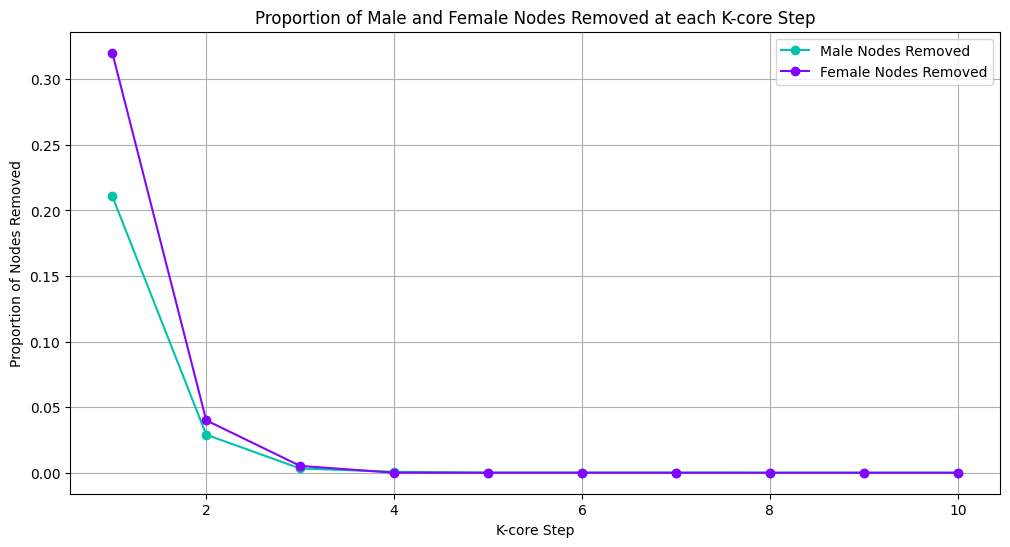

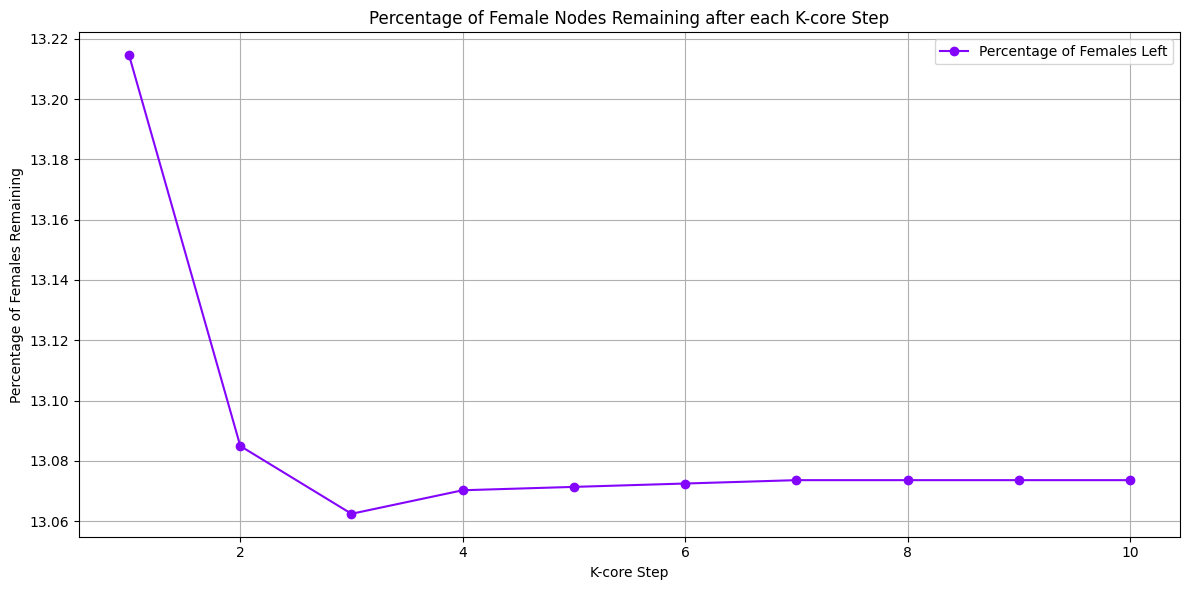

In [8]:
G_kcore_en = k_core_func(df_en, 2024,1)

Male total [6884, 5239, 5056, 5025, 5018, 5018, 5018, 5018, 5018, 5018]
Male removed [1645, 183, 31, 7, 0, 0, 0, 0, 0, 0]
Female total [815, 555, 523, 521, 520, 520, 520, 520, 520, 520]
Female removed [260, 32, 2, 1, 0, 0, 0, 0, 0, 0]
Male ratios [0.23895990703079606, 0.03493033021569002, 0.00613132911392405, 0.0013930348258706469, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Female ratios [0.31901840490797545, 0.05765765765765766, 0.0038240917782026767, 0.0019193857965451055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [9.57887469796341, 9.37443986377487, 9.394157951676885, 9.389671361502346, 9.389671361502346, 9.389671361502346, 9.389671361502346, 9.389671361502346, 9.389671361502346, 9.389671361502346]
Nodes remaining ratio: 0.7193141966489155


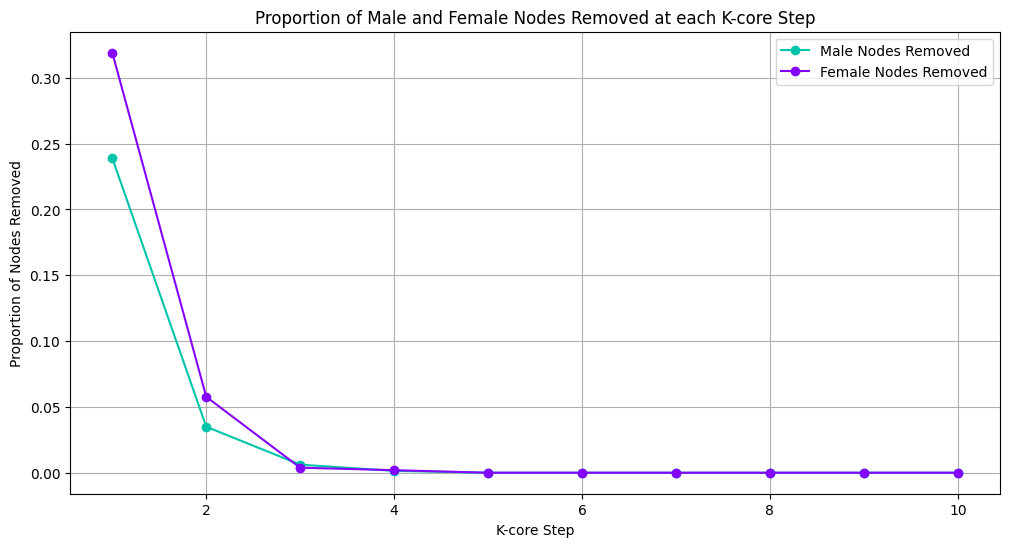

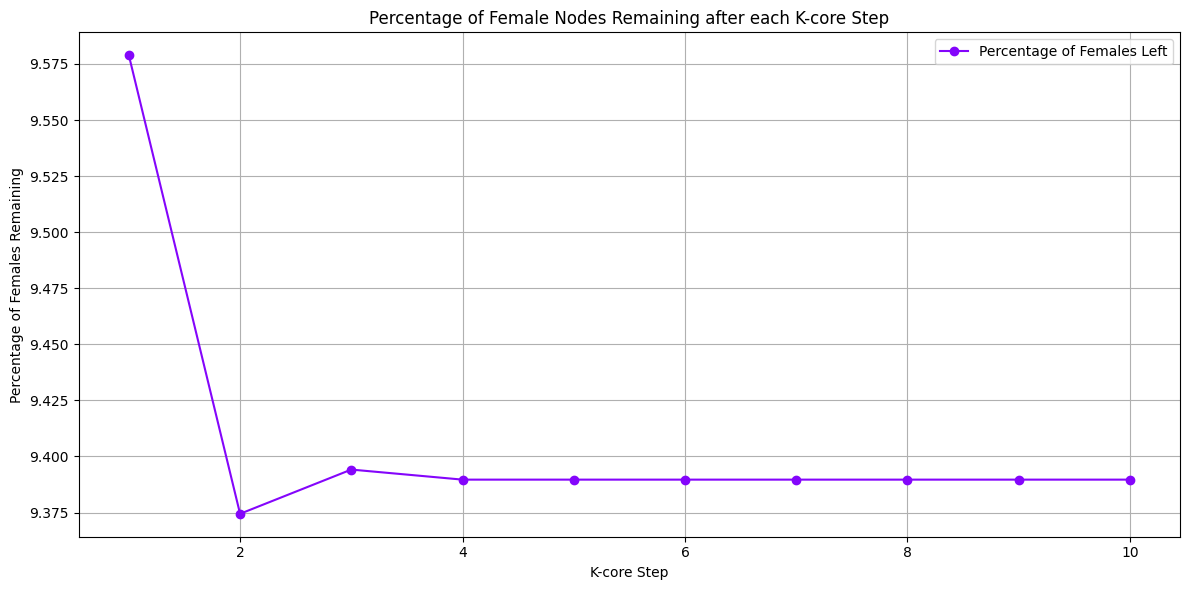

In [9]:
G_kcore_de = k_core_func(df_de, 2024,1)

Male total [6111, 4492, 4275, 4244, 4238, 4237, 4237, 4237, 4237, 4237]
Male removed [1619, 217, 31, 6, 1, 0, 0, 0, 0, 0]
Female total [903, 601, 571, 565, 564, 563, 563, 563, 563, 563]
Female removed [302, 30, 6, 1, 1, 0, 0, 0, 0, 0]
Male ratios [0.2649320896743577, 0.04830810329474622, 0.007251461988304094, 0.001413760603204524, 0.00023596035865974517, 0.0, 0.0, 0.0, 0.0, 0.0]
Female ratios [0.3344407530454042, 0.04991680532445923, 0.010507880910683012, 0.0017699115044247787, 0.0017730496453900709, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [11.800510504614177, 11.782913743293438, 11.748804325223539, 11.745106205747605, 11.729166666666666, 11.729166666666666, 11.729166666666666, 11.729166666666666, 11.729166666666666, 11.729166666666666]
Nodes remaining ratio: 0.6843455945252352


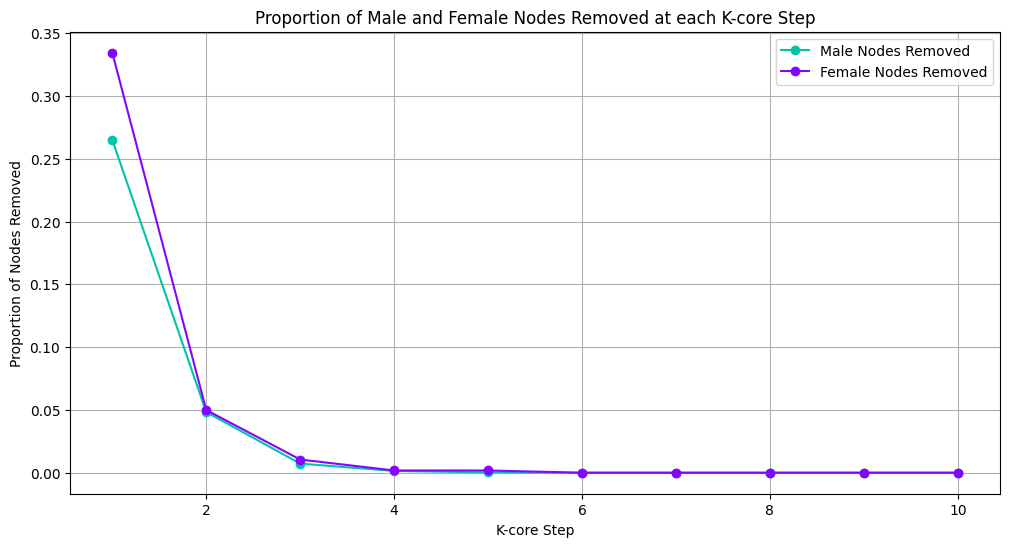

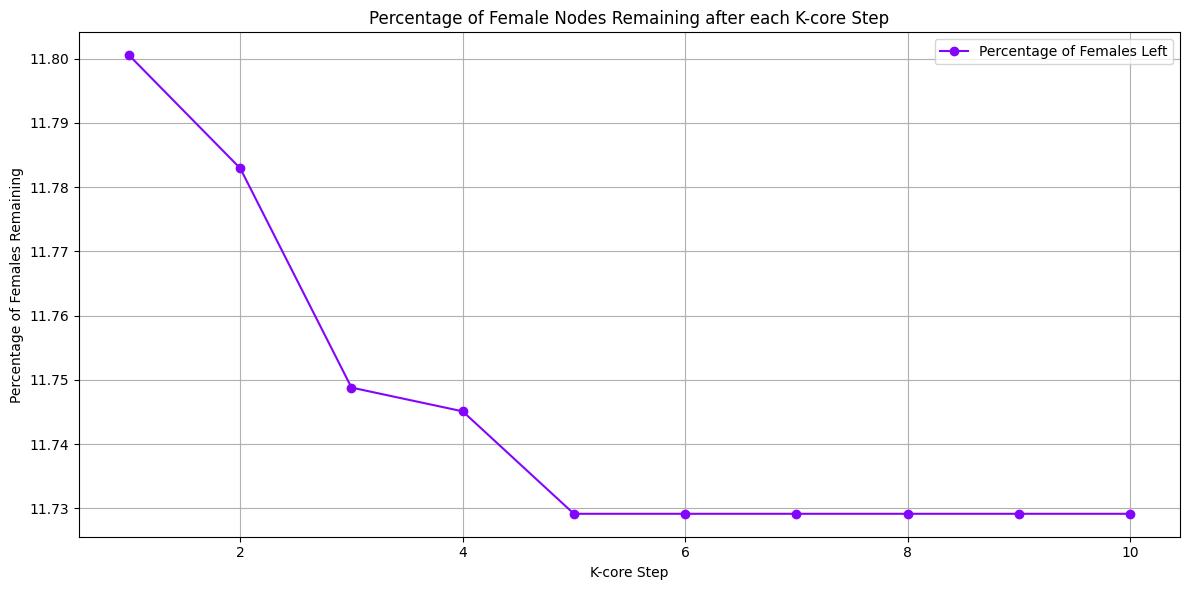

In [10]:
G_kcore_fr = k_core_func(df_fr, 2024,1)

Male total [4904, 2914, 2676, 2634, 2623, 2622, 2622, 2622, 2622, 2622]
Male removed [1990, 238, 42, 11, 1, 0, 0, 0, 0, 0]
Female total [569, 296, 260, 255, 253, 253, 253, 253, 253, 253]
Female removed [273, 36, 5, 2, 0, 0, 0, 0, 0, 0]
Male ratios [0.4057911908646003, 0.08167467398764584, 0.01569506726457399, 0.004176157934700076, 0.0003812428516965307, 0.0, 0.0, 0.0, 0.0, 0.0]
Female ratios [0.4797891036906854, 0.12162162162162163, 0.019230769230769232, 0.00784313725490196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [9.221183800623054, 8.85558583106267, 8.826583592938734, 8.796940194714882, 8.799999999999999, 8.799999999999999, 8.799999999999999, 8.799999999999999, 8.799999999999999, 8.799999999999999]
Nodes remaining ratio: 0.5253060478713686


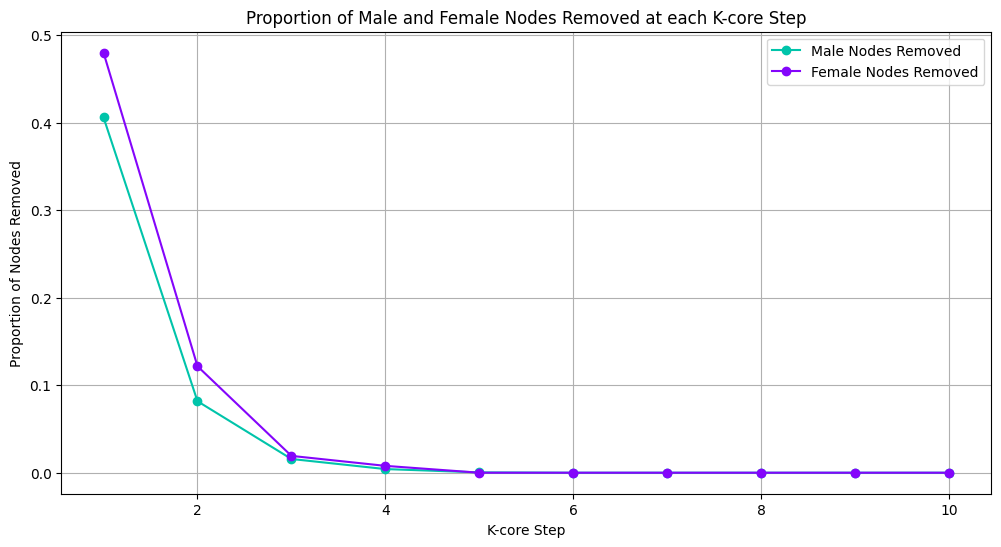

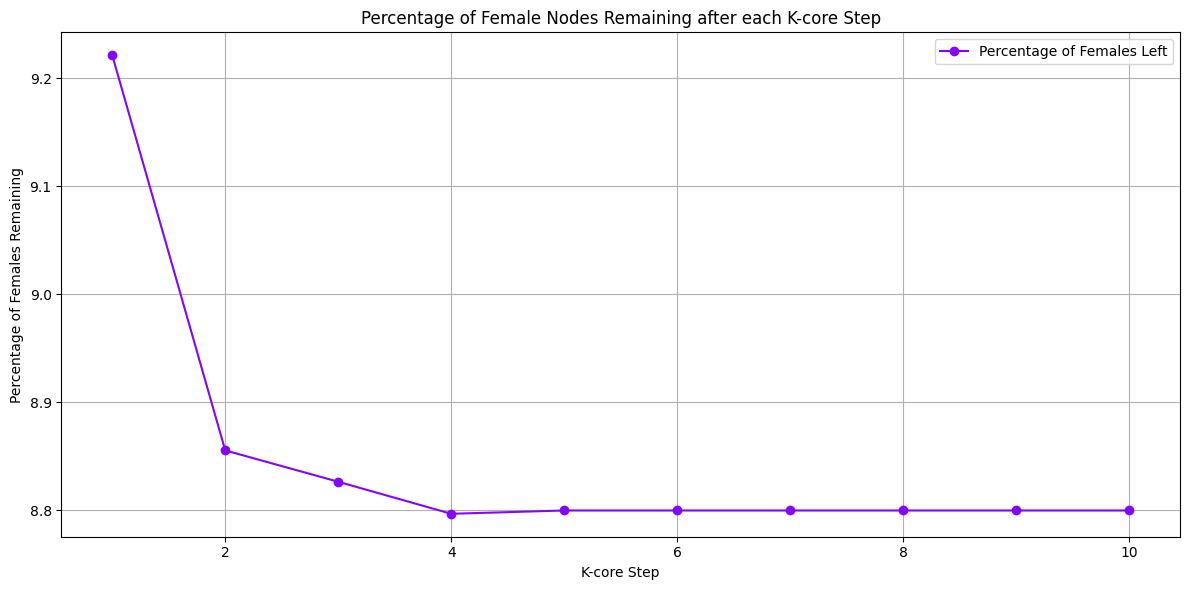

In [11]:
G_kcore_es = k_core_func(df_es, 2024,1)

### run for k=2,3,4

Male total [13333, 8138, 7352, 7187, 7143, 7132, 7127, 7125, 7124, 7123]
Male removed [5195, 786, 165, 44, 11, 5, 2, 1, 1, 0]
Female total [2357, 950, 800, 768, 763, 761, 760, 760, 760, 760]
Female removed [1407, 150, 32, 5, 2, 1, 0, 0, 0, 0]
Male ratios [0.38963474086852173, 0.09658392725485378, 0.022442872687704025, 0.006122165020175317, 0.0015399692006159878, 0.0007010656197420079, 0.0002806229830223095, 0.00014035087719298245, 0.00014037057832678272, 0.0]
Female ratios [0.5969452694102673, 0.15789473684210525, 0.04, 0.006510416666666667, 0.002621231979030144, 0.001314060446780552, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [10.453345070422536, 9.813542688910697, 9.654305468258958, 9.65089805211232, 9.641454453313063, 9.636110054520096, 9.63855421686747, 9.639776763064434, 9.640999619434226, 9.640999619434226]
Nodes remaining ratio: 0.5024219247928617


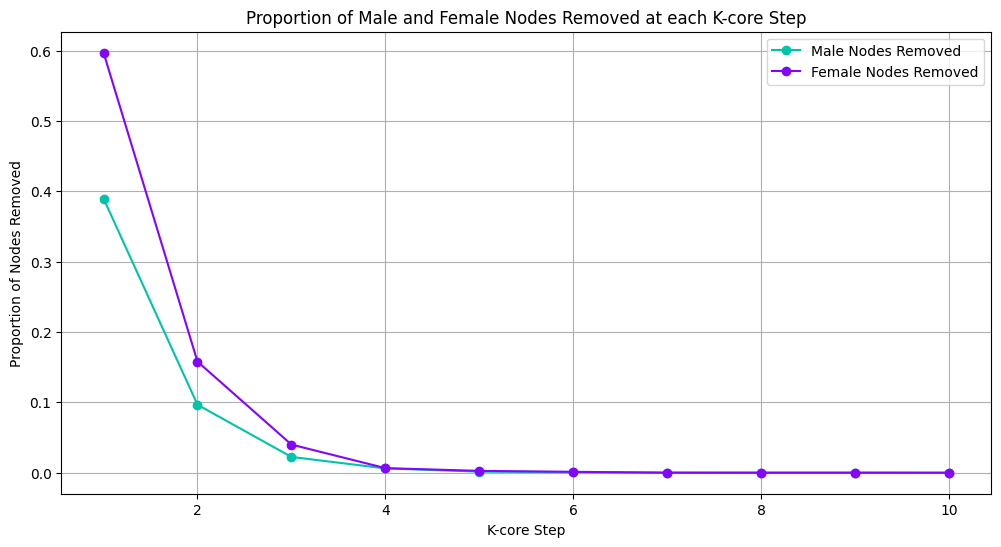

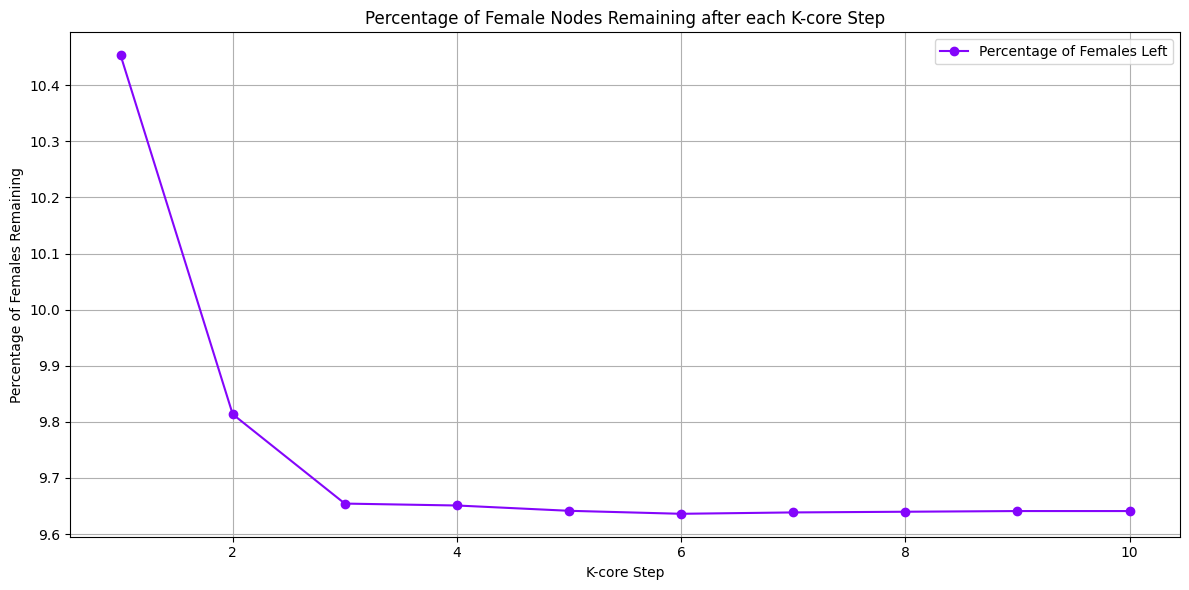

In [12]:
G_kcore_en = k_core_func(df_en, 2024,2)

Male total [13333, 6416, 5404, 5130, 5052, 5025, 5010, 5004, 5001, 4998]
Male removed [6917, 1012, 274, 78, 27, 15, 6, 3, 3, 0]
Female total [2357, 628, 474, 439, 430, 427, 427, 427, 427, 427]
Female removed [1729, 154, 35, 9, 3, 0, 0, 0, 0, 0]
Male ratios [0.5187879696992425, 0.15773067331670823, 0.05070318282753516, 0.0152046783625731, 0.005344418052256532, 0.0029850746268656717, 0.0011976047904191617, 0.0005995203836930455, 0.0005998800239952009, 0.0]
Female ratios [0.7335596096733136, 0.24522292993630573, 0.07383966244725738, 0.02050113895216401, 0.0069767441860465115, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [8.915388983532084, 8.063967335828513, 7.882923325552165, 7.843852608537031, 7.831988261188555, 7.85359573294096, 7.862272141410422, 7.866617538688284, 7.870967741935483, 7.870967741935483]
Nodes remaining ratio: 0.345761631612492


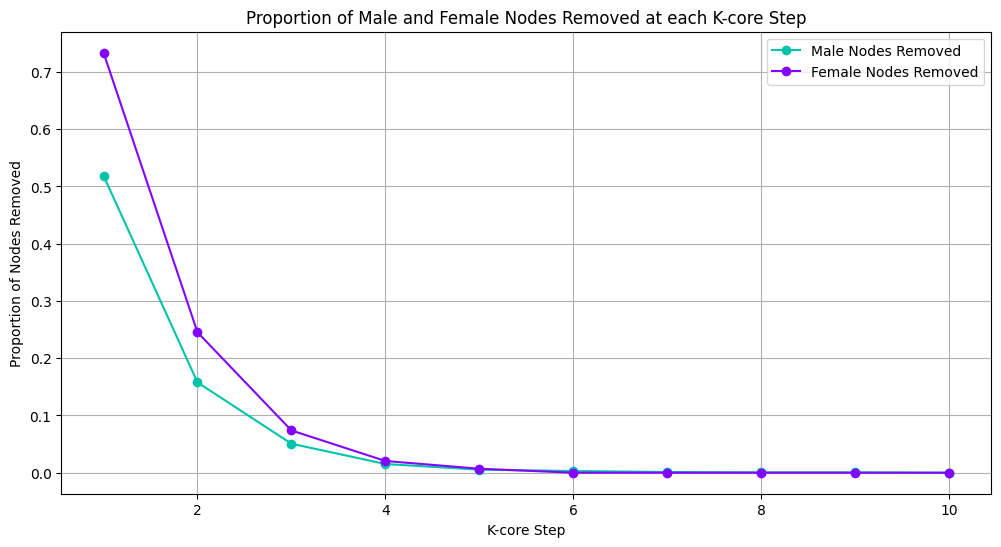

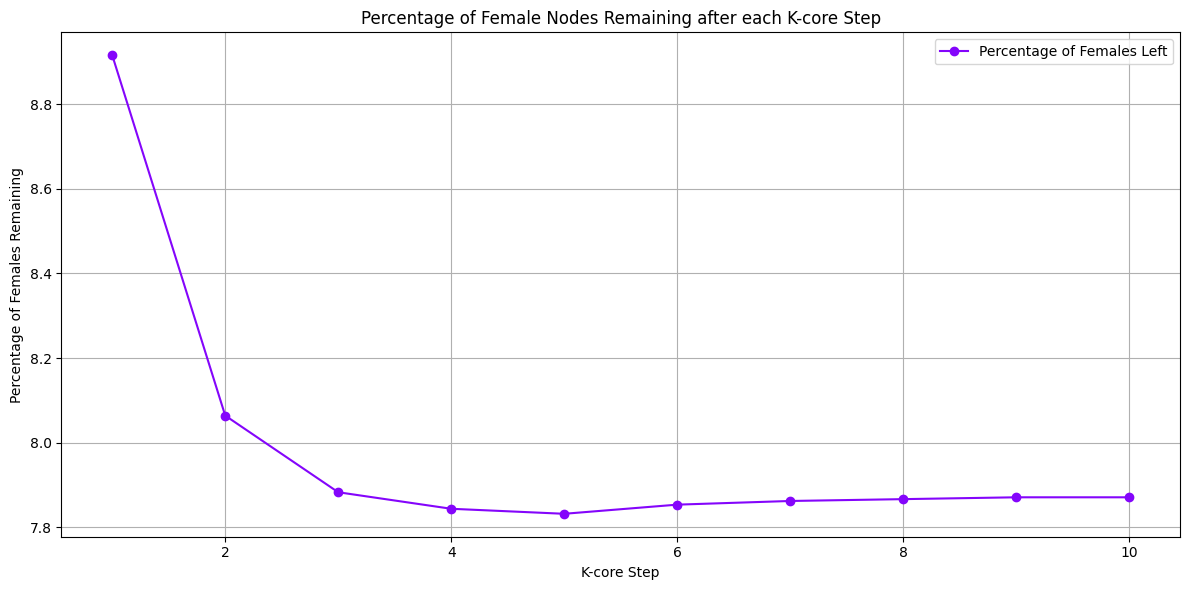

In [13]:
G_kcore_en = k_core_func(df_en, 2024,3)

Male total [13333, 5146, 3928, 3504, 3359, 3300, 3271, 3257, 3247, 3241]
Male removed [8187, 1218, 424, 145, 59, 29, 14, 10, 6, 2]
Female total [2357, 421, 271, 250, 236, 228, 225, 221, 221, 220]
Female removed [1936, 150, 21, 14, 8, 3, 4, 0, 1, 0]
Male ratios [0.6140403510087752, 0.23668869024485037, 0.1079429735234216, 0.04138127853881279, 0.017564751414111342, 0.008787878787878787, 0.004280036686028737, 0.003070310101320233, 0.0018478595626732369, 0.000617093489663684]
Female ratios [0.821383114128129, 0.35629453681710216, 0.07749077490774908, 0.056, 0.03389830508474576, 0.013157894736842105, 0.017777777777777778, 0.0, 0.004524886877828055, 0.0]
Female percentage remaining: [7.562421411891504, 6.4539175994284355, 6.659563132658497, 6.564673157162726, 6.462585034013606, 6.435926773455377, 6.354226566992524, 6.372549019607843, 6.356544351343542, 6.360219716681121]
Nodes remaining ratio: 0.2204588910133843


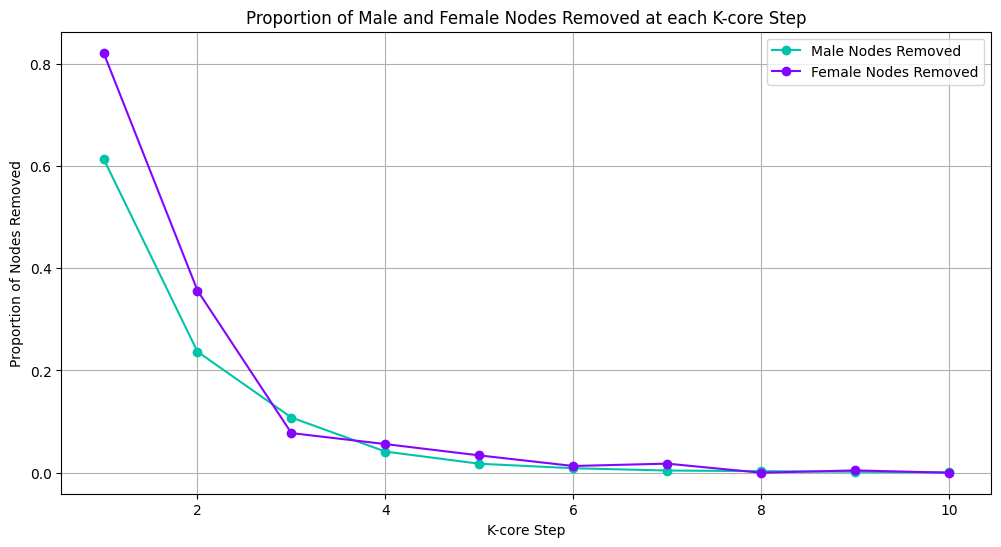

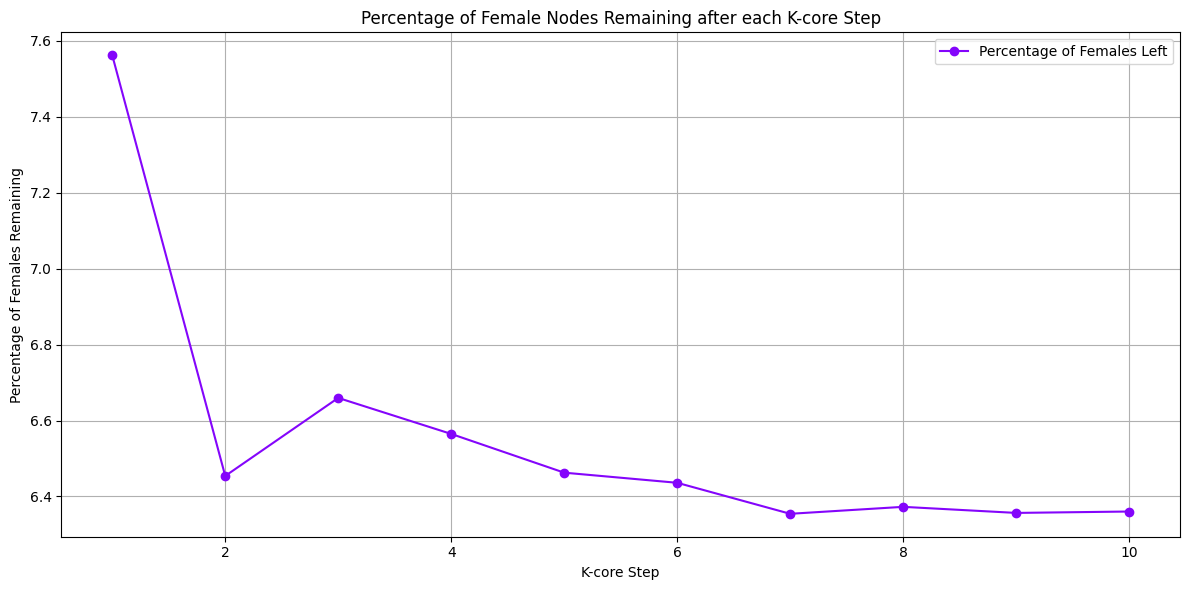

In [14]:
G_kcore_en = k_core_func(df_en, 2024,4)

Male total [6884, 4128, 3746, 3663, 3644, 3636, 3634, 3633, 3632, 3632]
Male removed [2756, 382, 83, 19, 8, 2, 1, 1, 0, 0]
Female total [815, 377, 326, 308, 301, 301, 301, 301, 301, 301]
Female removed [438, 51, 18, 7, 0, 0, 0, 0, 0, 0]
Male ratios [0.40034863451481695, 0.09253875968992248, 0.02215696743192739, 0.005187005187005187, 0.0021953896816684962, 0.00055005500550055, 0.000275178866263071, 0.0002752546105147261, 0.0, 0.0]
Female ratios [0.5374233128834356, 0.13527851458885942, 0.05521472392638037, 0.022727272727272728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [8.368479467258602, 8.00589390962672, 7.756232686980609, 7.6299112801013935, 7.645415290830582, 7.649301143583227, 7.6512455516014235, 7.653190948385456, 7.653190948385456, 7.653190948385456]
Nodes remaining ratio: 0.5108455643590076


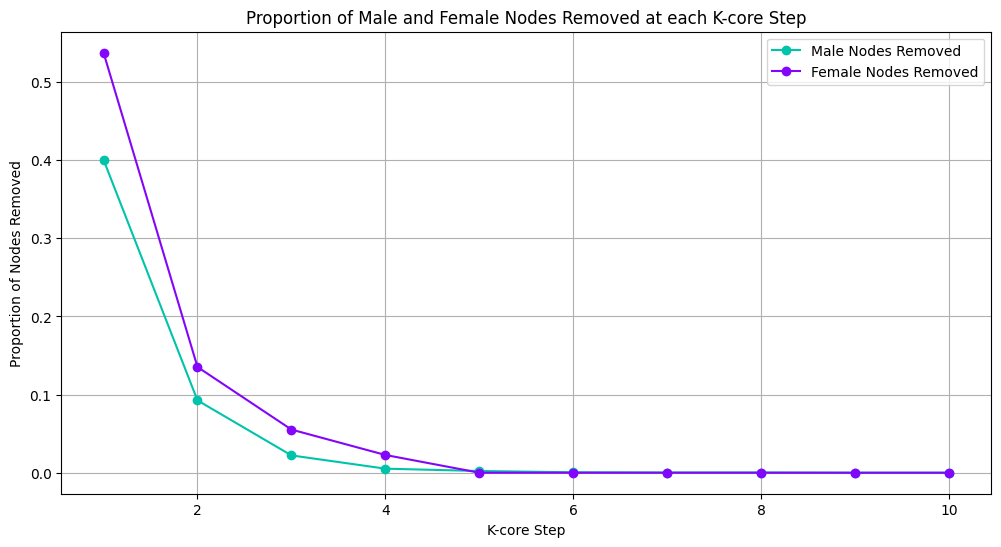

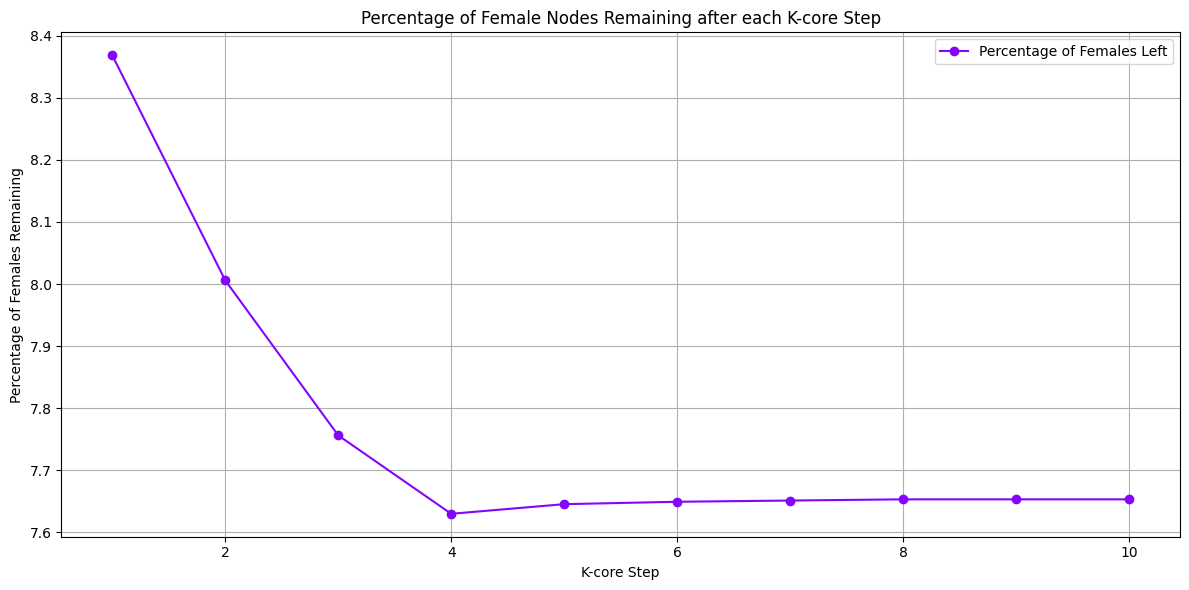

In [30]:
G_kcore_de = k_core_func(df_de, 2024,2)

Male total [6884, 3282, 2756, 2605, 2550, 2521, 2511, 2509, 2508, 2507]
Male removed [3602, 526, 151, 55, 29, 10, 2, 1, 1, 0]
Female total [815, 267, 202, 180, 177, 176, 175, 175, 175, 175]
Female removed [548, 65, 22, 3, 1, 1, 0, 0, 0, 0]
Male ratios [0.5232423009877978, 0.16026812918951858, 0.05478955007256894, 0.02111324376199616, 0.011372549019607842, 0.003966679888932963, 0.0007964954201513341, 0.00039856516540454366, 0.00039872408293460925, 0.0]
Female ratios [0.6723926380368098, 0.24344569288389514, 0.10891089108910891, 0.016666666666666666, 0.005649717514124294, 0.005681818181818182, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [7.523245984784446, 6.8289384719405, 6.463195691202872, 6.490649064906491, 6.525769373377827, 6.515264333581534, 6.5201192250372575, 6.522549385016772, 6.524981357196122, 6.524981357196122]
Nodes remaining ratio: 0.34835692947135993


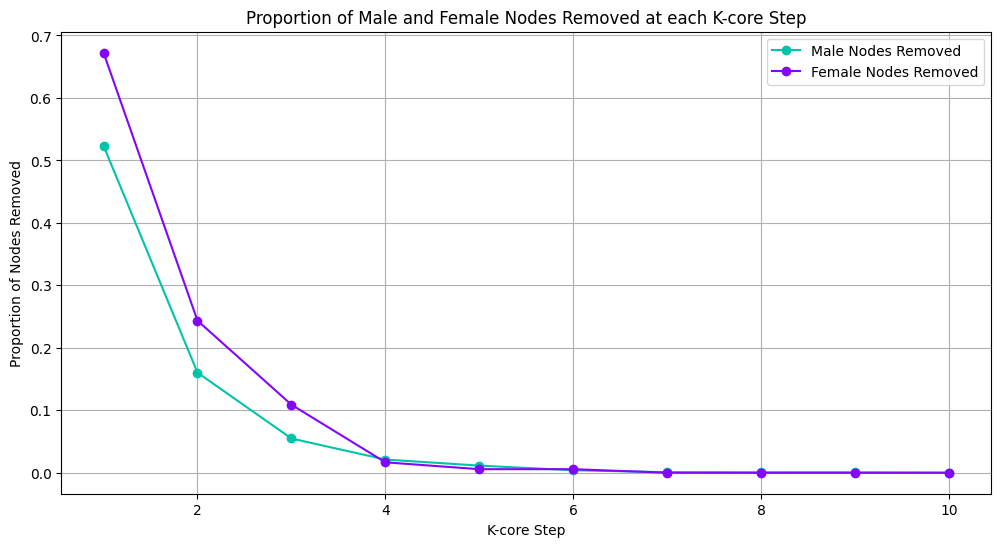

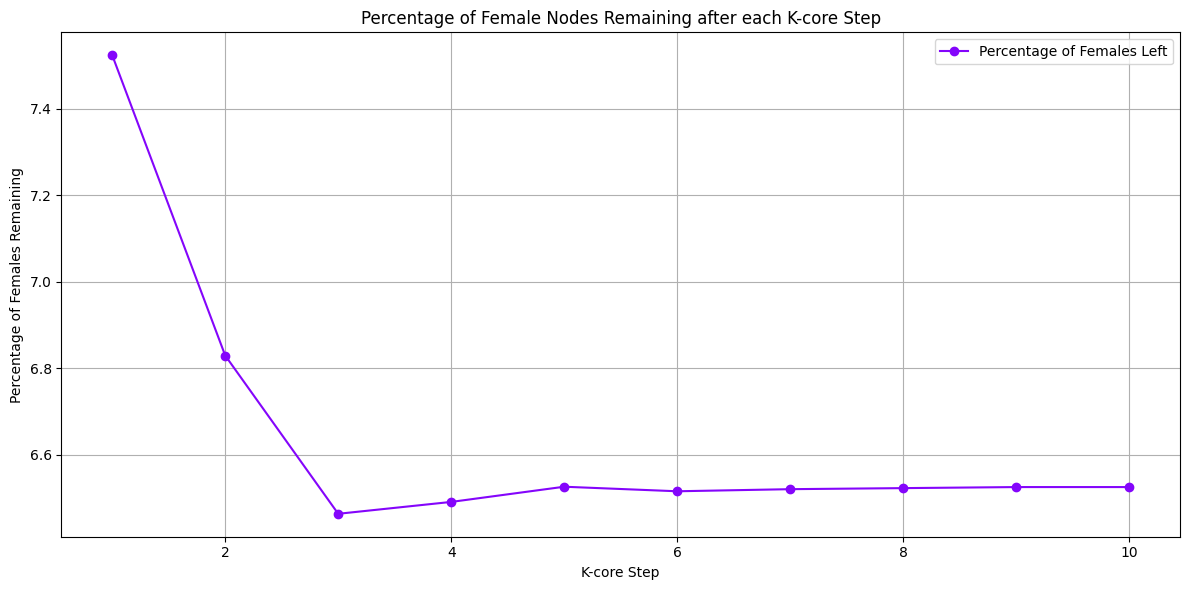

In [31]:
G_kcore_de = k_core_func(df_de, 2024,3)

Male total [6884, 2614, 1948, 1750, 1664, 1634, 1617, 1607, 1600, 1596]
Male removed [4270, 666, 198, 86, 30, 17, 10, 7, 4, 3]
Female total [815, 185, 124, 109, 98, 95, 95, 95, 95, 94]
Female removed [630, 61, 15, 11, 3, 0, 0, 0, 1, 0]
Male ratios [0.6202789076118536, 0.25478194338179033, 0.10164271047227925, 0.04914285714285714, 0.018028846153846152, 0.01040391676866585, 0.006184291898577613, 0.0043559427504667085, 0.0025, 0.0018796992481203006]
Female ratios [0.7730061349693251, 0.32972972972972975, 0.12096774193548387, 0.10091743119266056, 0.030612244897959183, 0.0, 0.0, 0.0, 0.010526315789473684, 0.0]
Female percentage remaining: [6.609503394069311, 5.984555984555985, 5.86336740182894, 5.561861520998865, 5.4945054945054945, 5.549065420560748, 5.581668625146886, 5.604719764011799, 5.562130177514793, 5.572021339656195]
Nodes remaining ratio: 0.21911936615144825


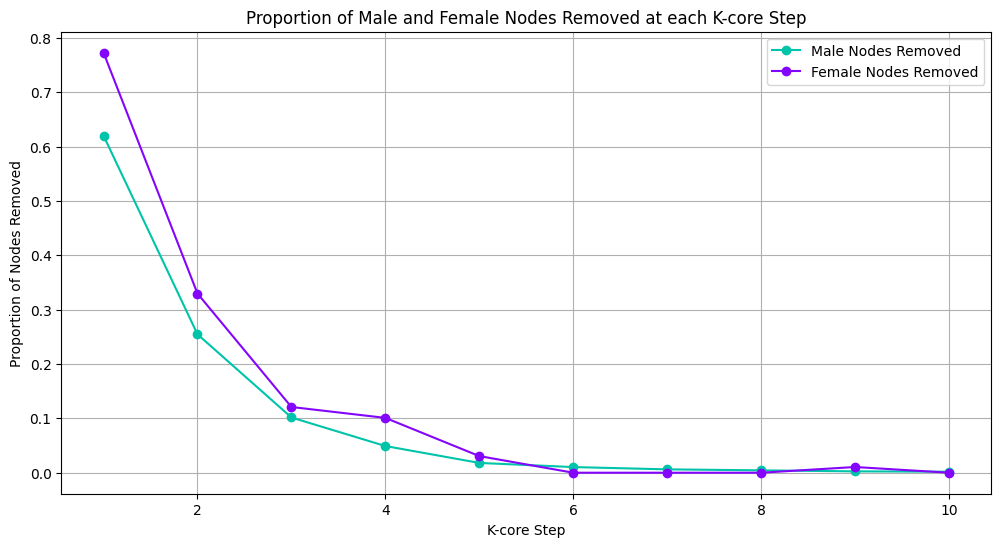

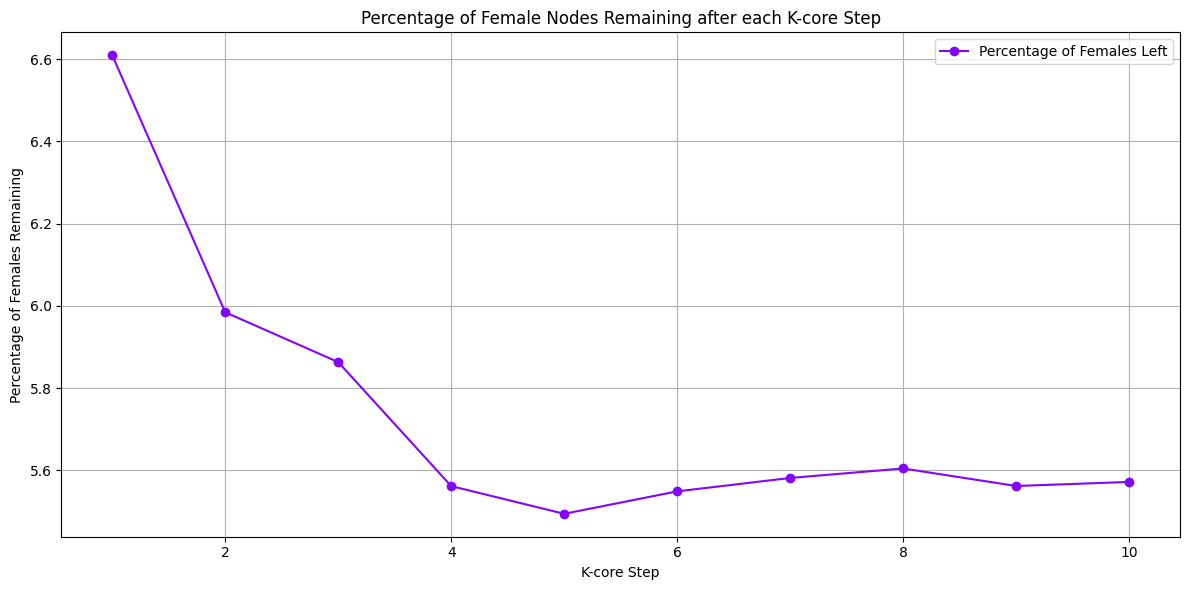

In [32]:
G_kcore_de = k_core_func(df_de, 2024,4)

Male total [6111, 3365, 2937, 2840, 2810, 2804, 2802, 2801, 2801, 2801]
Male removed [2746, 428, 97, 30, 6, 2, 1, 0, 0, 0]
Female total [903, 380, 319, 306, 303, 300, 299, 299, 299, 299]
Female removed [523, 61, 13, 3, 3, 1, 0, 0, 0, 0]
Male ratios [0.4493536246113566, 0.12719167904903417, 0.03302689819543752, 0.01056338028169014, 0.002135231316725979, 0.0007132667617689016, 0.00035688793718772306, 0.0, 0.0, 0.0]
Female ratios [0.5791805094130675, 0.16052631578947368, 0.04075235109717868, 0.00980392156862745, 0.009900990099009901, 0.0033333333333333335, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [10.14686248331108, 9.797297297297296, 9.726636999364272, 9.73337616447157, 9.664948453608249, 9.64205095130603, 9.64516129032258, 9.64516129032258, 9.64516129032258, 9.64516129032258]
Nodes remaining ratio: 0.4419731964642144


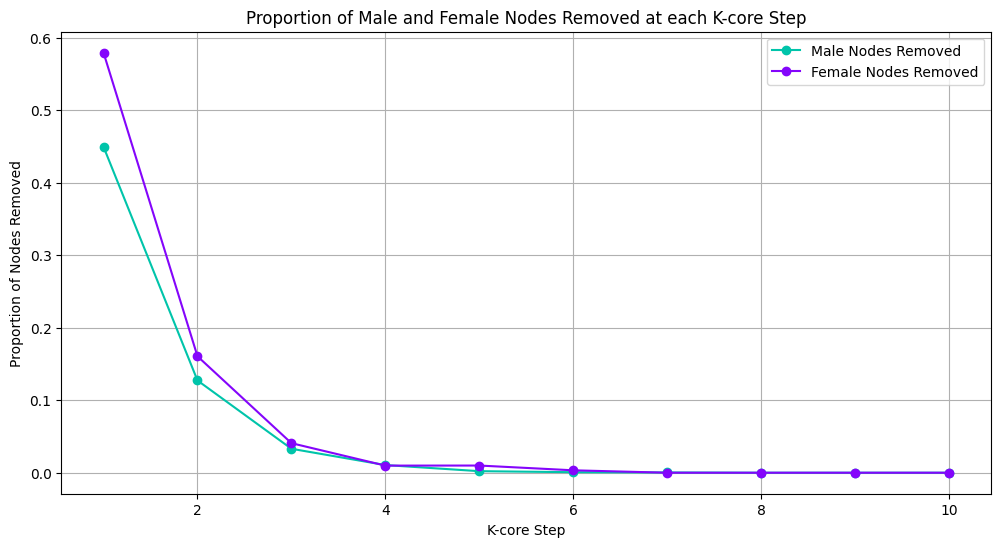

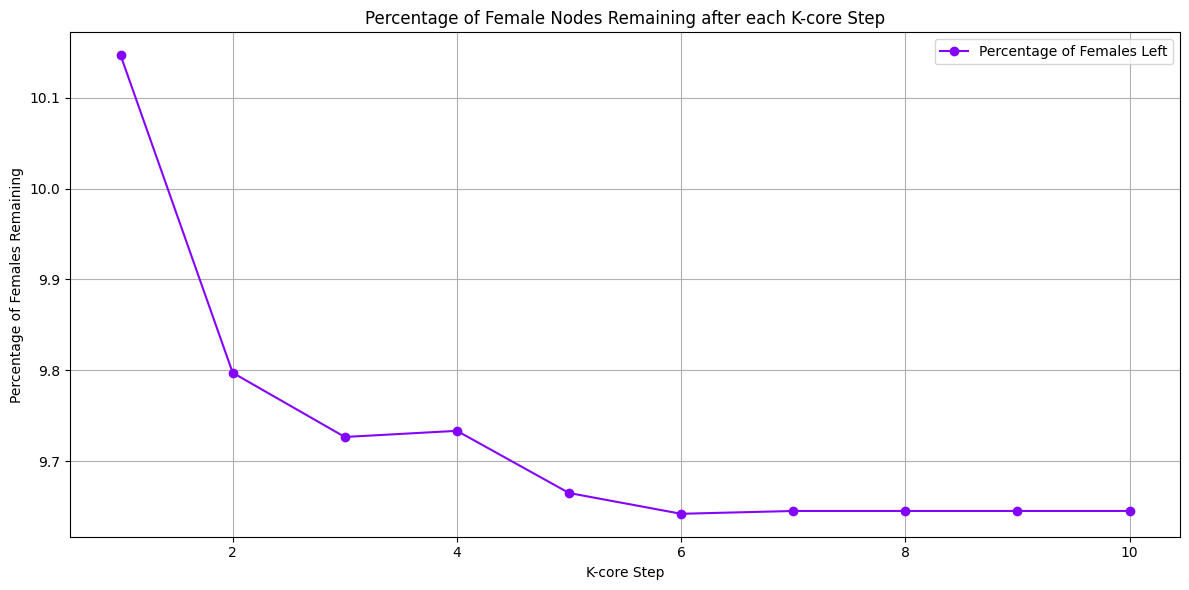

In [33]:
G_kcore_fr = k_core_func(df_fr, 2024,2)

Male total [6111, 2612, 2055, 1922, 1875, 1843, 1833, 1828, 1825, 1823]
Male removed [3499, 557, 133, 47, 32, 10, 5, 3, 2, 0]
Female total [903, 271, 196, 171, 162, 159, 159, 159, 159, 159]
Female removed [632, 75, 25, 9, 3, 0, 0, 0, 0, 0]
Male ratios [0.5725740468008509, 0.21324655436447168, 0.06472019464720194, 0.02445369406867846, 0.017066666666666667, 0.005425935973955507, 0.002727768685215494, 0.0016411378555798686, 0.001095890410958904, 0.0]
Female ratios [0.6998892580287929, 0.2767527675276753, 0.12755102040816327, 0.05263157894736842, 0.018518518518518517, 0.0, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [9.399930627818245, 8.707241226121724, 8.170090778786431, 7.952871870397643, 7.942057942057942, 7.981927710843372, 8.002013085052843, 8.014112903225806, 8.022199798183653, 8.022199798183653]
Nodes remaining ratio: 0.2825777017393784


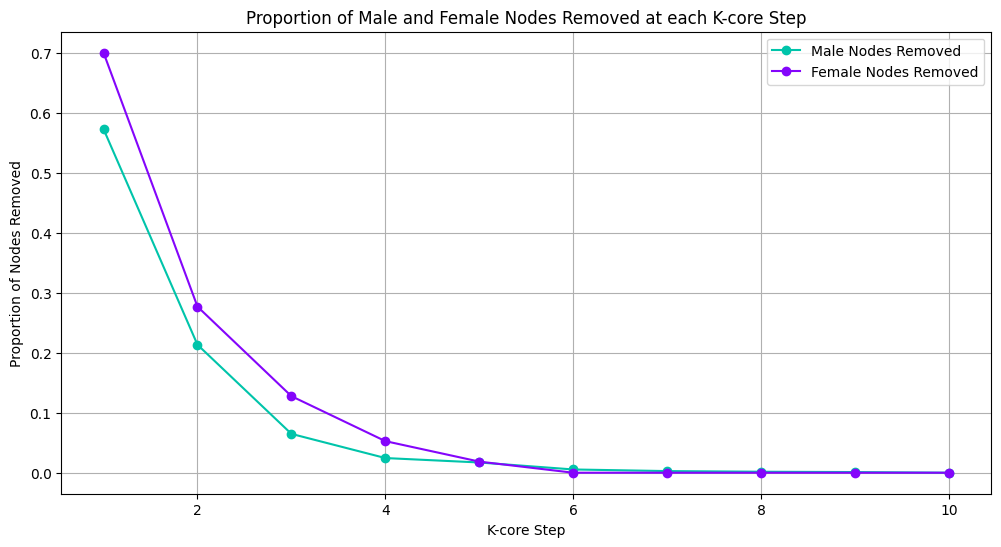

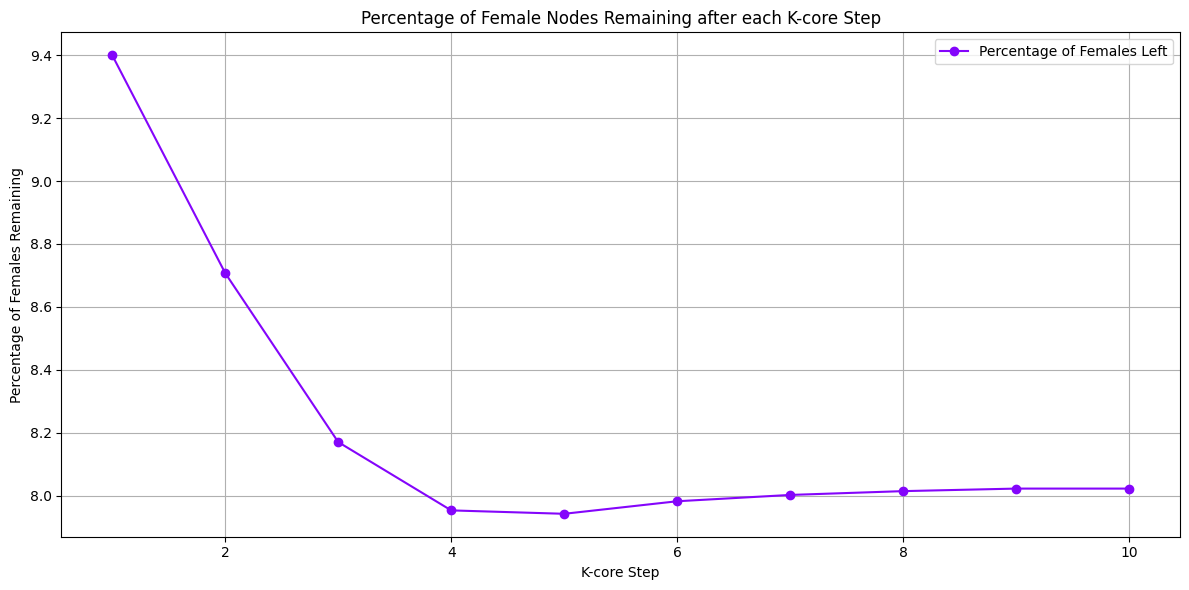

In [34]:
G_kcore_fr = k_core_func(df_fr, 2024,3)

Male total [6111, 1992, 1380, 1179, 1086, 1043, 1012, 992, 978, 968]
Male removed [4119, 612, 201, 93, 43, 31, 20, 14, 10, 4]
Female total [903, 183, 109, 94, 92, 89, 89, 89, 88, 88]
Female removed [720, 74, 15, 2, 3, 0, 0, 1, 0, 0]
Male ratios [0.6740304369170349, 0.3072289156626506, 0.14565217391304347, 0.07888040712468193, 0.03959484346224678, 0.029721955896452542, 0.019762845849802372, 0.014112903225806451, 0.010224948875255624, 0.004132231404958678]
Female ratios [0.7973421926910299, 0.40437158469945356, 0.13761467889908258, 0.02127659574468085, 0.03260869565217391, 0.0, 0.0, 0.011235955056179775, 0.0, 0.0]
Female percentage remaining: [8.413793103448276, 7.320349227669578, 7.384131971720345, 7.809847198641766, 7.862190812720849, 8.083560399636694, 8.233117483811286, 8.25515947467167, 8.333333333333332, 8.365019011406844]
Nodes remaining ratio: 0.14998574280011406


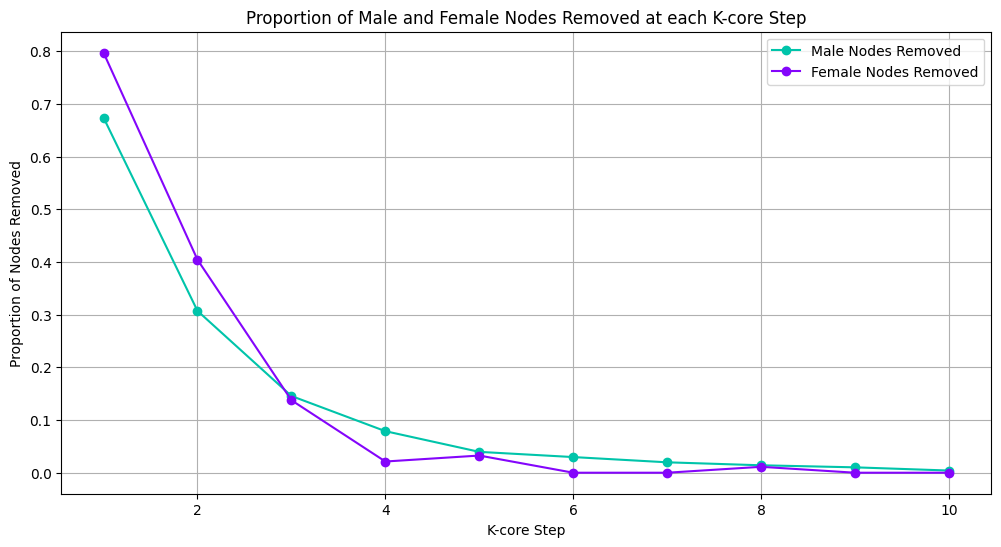

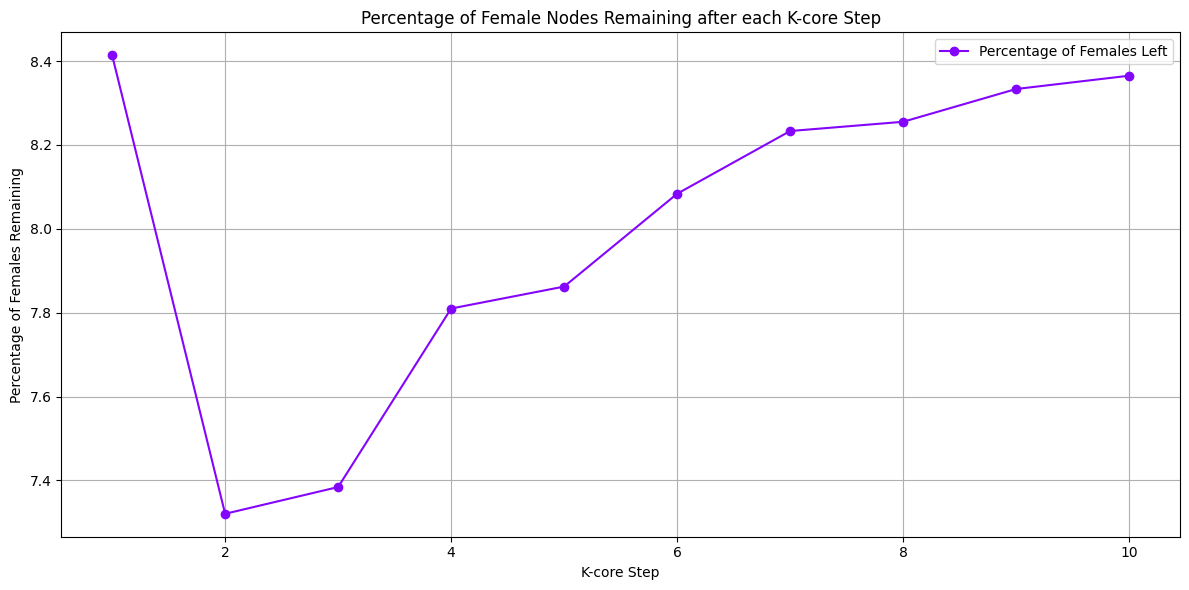

In [35]:
G_kcore_fr = k_core_func(df_fr, 2024,4)

Male total [4904, 2052, 1657, 1558, 1530, 1523, 1522, 1520, 1519, 1519]
Male removed [2852, 395, 99, 28, 7, 1, 2, 1, 0, 0]
Female total [569, 185, 133, 121, 119, 119, 118, 118, 118, 118]
Female removed [384, 52, 12, 2, 0, 1, 0, 0, 0, 0]
Male ratios [0.5815660685154975, 0.19249512670565302, 0.05974652987326494, 0.01797175866495507, 0.004575163398692811, 0.0006565988181221273, 0.001314060446780552, 0.0006578947368421052, 0.0, 0.0]
Female ratios [0.6748681898066784, 0.2810810810810811, 0.09022556390977443, 0.01652892561983471, 0.0, 0.008403361344537815, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [8.270004470272687, 7.430167597765363, 7.206670637284097, 7.216494845360824, 7.2472594397076735, 7.1951219512195115, 7.203907203907203, 7.2083078802687846, 7.2083078802687846, 7.2083078802687846]
Nodes remaining ratio: 0.2991046957792801


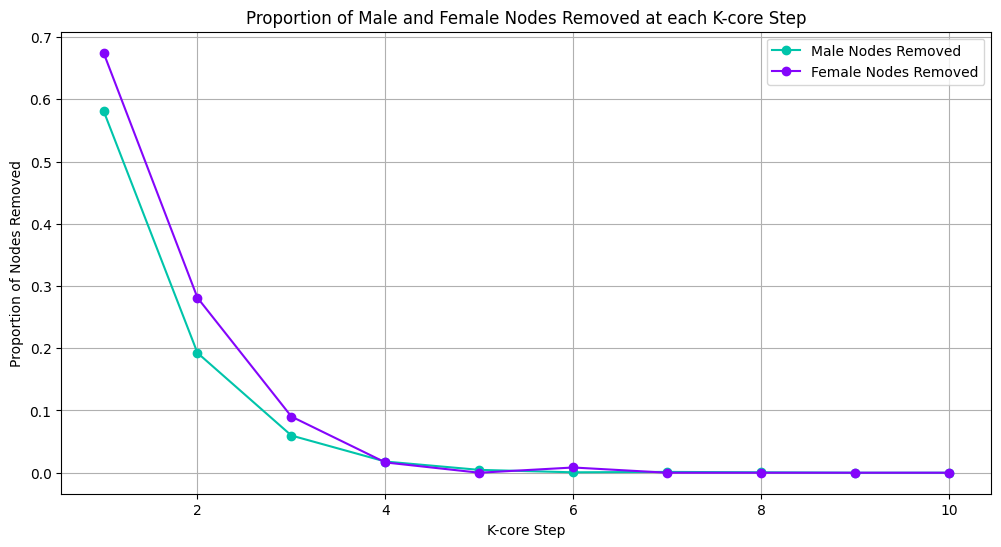

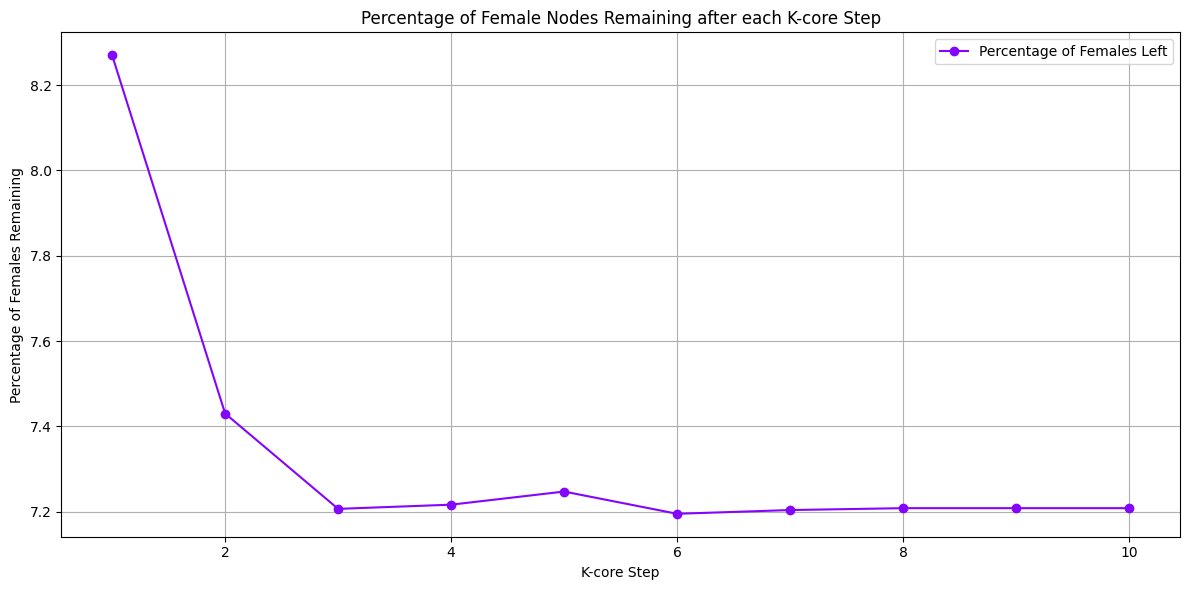

In [36]:
G_kcore_es = k_core_func(df_es, 2024,2)

Male total [4904, 1572, 1138, 1027, 989, 972, 958, 951, 949, 949]
Male removed [3332, 434, 111, 38, 17, 14, 7, 2, 0, 0]
Female total [569, 114, 72, 65, 63, 62, 61, 61, 61, 61]
Female removed [455, 42, 7, 2, 1, 1, 0, 0, 0, 0]
Male ratios [0.6794453507340946, 0.27608142493638677, 0.09753954305799649, 0.03700097370983447, 0.017189079878665317, 0.01440329218106996, 0.007306889352818371, 0.002103049421661409, 0.0, 0.0]
Female ratios [0.7996485061511424, 0.3684210526315789, 0.09722222222222222, 0.03076923076923077, 0.015873015873015872, 0.016129032258064516, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [6.761565836298933, 5.950413223140496, 5.952380952380952, 5.988593155893536, 5.996131528046422, 5.986261040235525, 6.027667984189724, 6.03960396039604, 6.03960396039604, 6.03960396039604]
Nodes remaining ratio: 0.18454229855655033


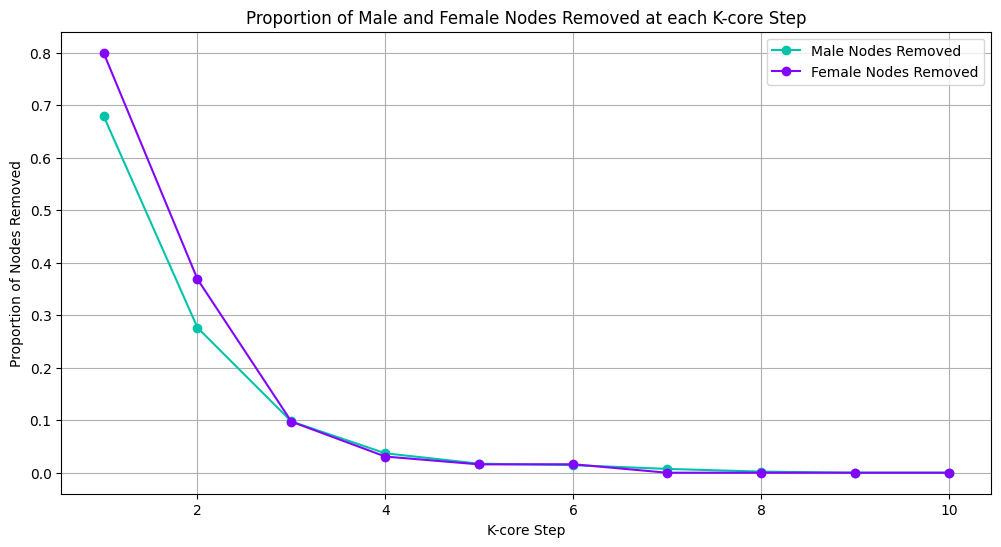

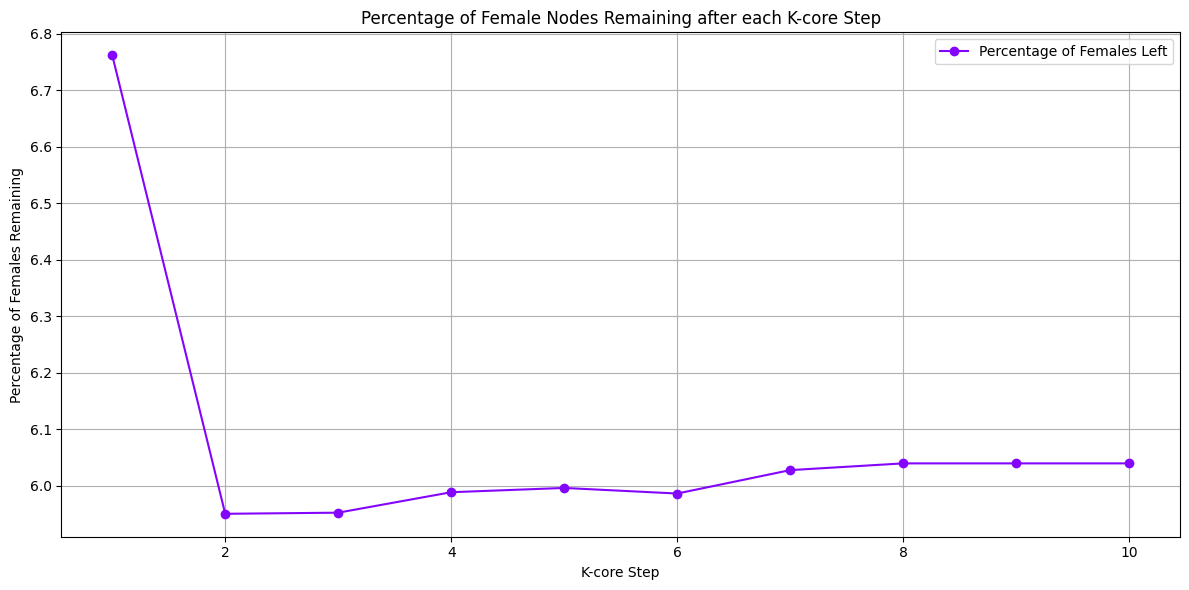

In [37]:
G_kcore_es = k_core_func(df_es, 2024,3)

Male total [4904, 1185, 767, 635, 575, 531, 513, 501, 492, 489]
Male removed [3719, 418, 132, 60, 44, 18, 12, 9, 3, 1]
Female total [569, 79, 43, 35, 32, 31, 30, 30, 30, 30]
Female removed [490, 36, 8, 3, 1, 1, 0, 0, 0, 0]
Male ratios [0.7583605220228385, 0.3527426160337553, 0.17209908735332463, 0.09448818897637795, 0.07652173913043478, 0.03389830508474576, 0.023391812865497075, 0.017964071856287425, 0.006097560975609756, 0.002044989775051125]
Female ratios [0.8611599297012302, 0.45569620253164556, 0.18604651162790697, 0.08571428571428572, 0.03125, 0.03225806451612903, 0.0, 0.0, 0.0, 0.0]
Female percentage remaining: [6.25, 5.3086419753086425, 5.223880597014925, 5.2718286655683695, 5.5160142348754455, 5.524861878453039, 5.649717514124294, 5.747126436781609, 5.780346820809249, 5.7915057915057915]
Nodes remaining ratio: 0.09464644619038919


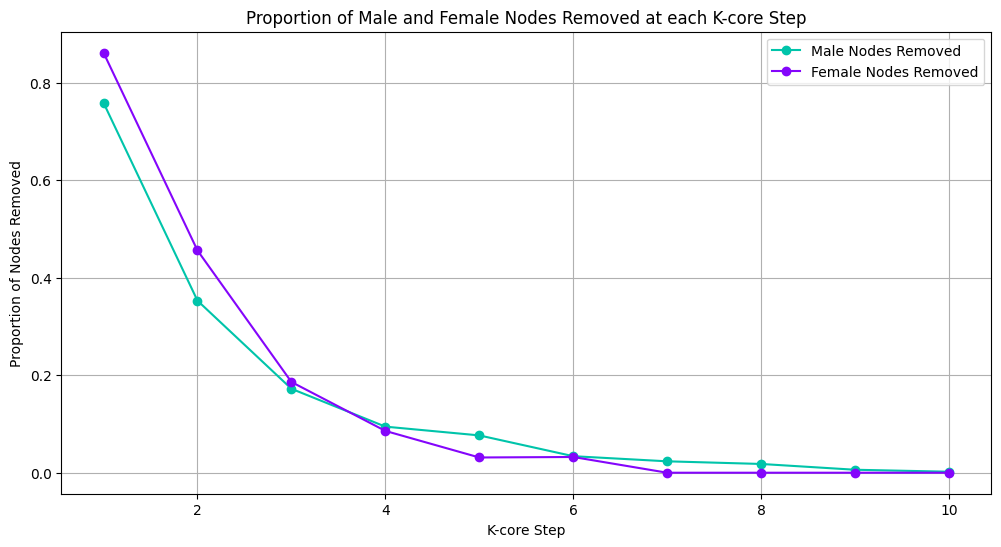

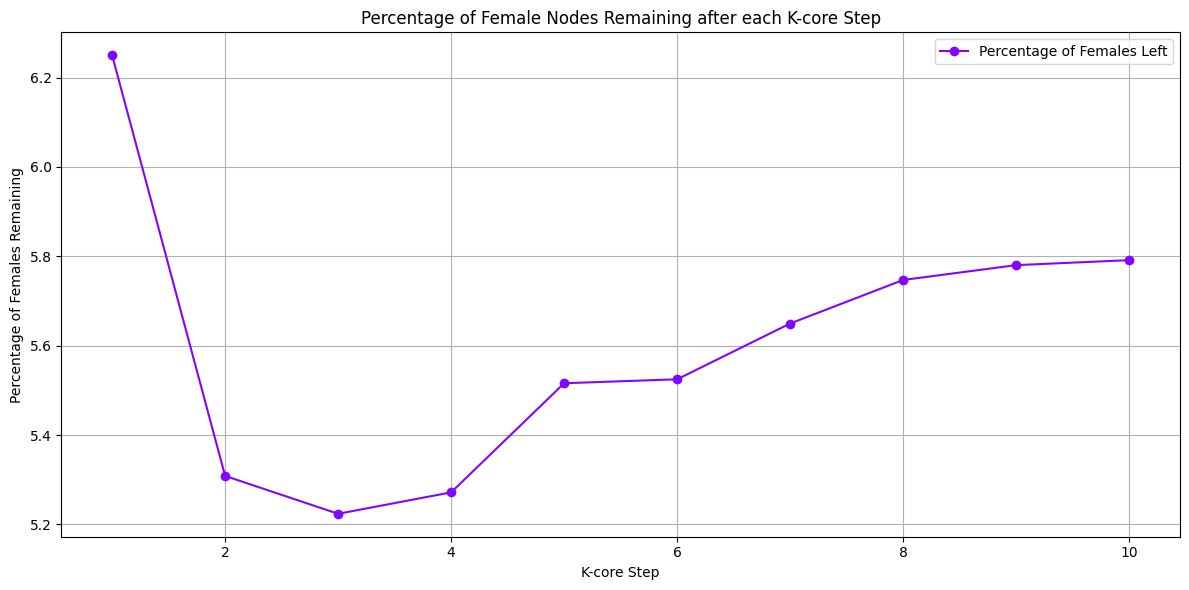

In [38]:
G_kcore_es = k_core_func(df_es, 2024,4)

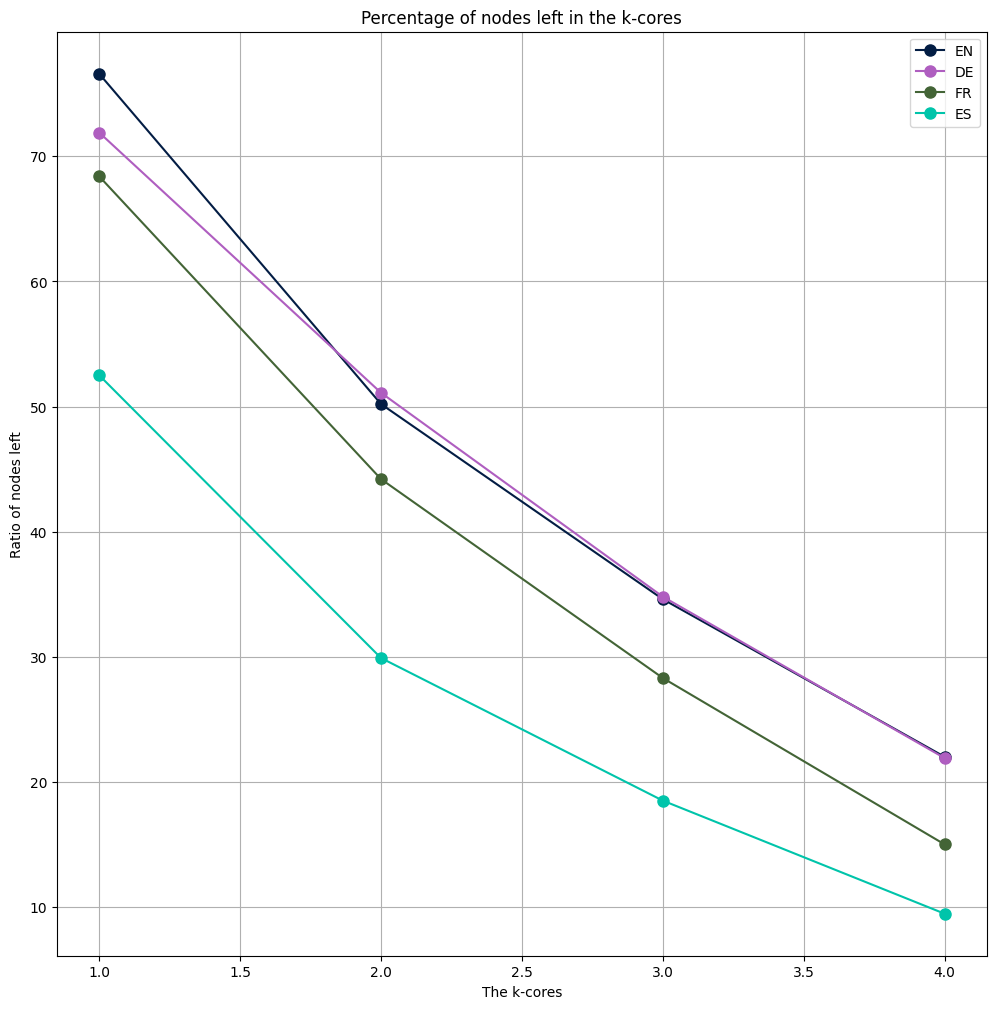

In [52]:
core = [1, 2, 3, 4]
en_nodes = [76.6, 50.2, 34.6, 22.0]
en_nodes_female = [35.1, 67.8, 81.9, 90.7]
en_nodes_male = [23.7, 46.6, 62.5, 75.8]
en_nodes_female_left = [13.1, 9.35, 7.87, 6.36]

de_nodes = [71.9, 51.1, 34.8, 21.9]
de_nodes_female = [36.2, 63.1, 78.5, 88.7]
de_nodes_male = [27.1, 47.2, 63.6, 76.9]
de_nodes_female_left = [9.83, 7.65, 6.52, 5.57]

fr_nodes = [68.4, 44.2, 28.3, 15.0]
fr_nodes_female = [37.7, 66.9, 82.4, 90.6]
fr_nodes_male = [30.6, 54.2, 70.2, 84.4]
fr_nodes_female_left = [11.7, 9.65, 8.02, 8.37]

es_nodes = [52.5, 29.9, 18.5, 9.46]
es_nodes_female = [55.5, 79.3, 89.3, 94.7]
es_nodes_male = [46.5, 69.0, 80.6, 90.0]
es_nodes_female_left = [8.80, 7.21, 6.04, 5.79]


# Plot each line
plt.figure(figsize=(12, 12))
plt.plot(core, en_nodes, marker='o', label='EN', color='#031D44', markersize=8)
plt.plot(core, de_nodes, marker='o', label='DE', color='#AF5EC0', markersize=8)
plt.plot(core, fr_nodes, marker='o', label='FR', color='#436436', markersize=8)
plt.plot(core, es_nodes, marker='o', label='ES', color='#00C4AA', markersize=8)

# Add labels, title, and legend
plt.xlabel('The k-cores')
plt.ylabel('Ratio of nodes left')
plt.title('Percentage of nodes left in the k-cores')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


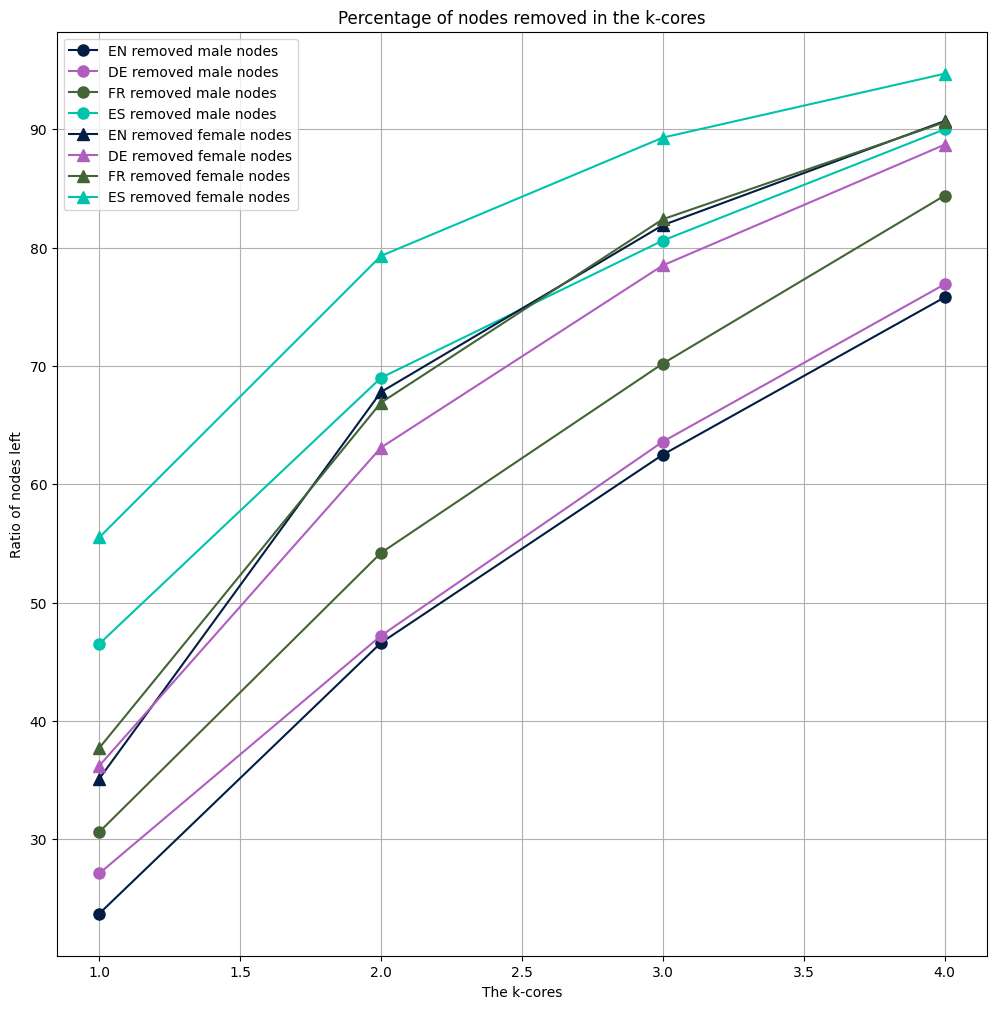

In [51]:
# Plot each line
plt.figure(figsize=(12, 12))

plt.plot(core, en_nodes_male, marker='o', label='EN removed male nodes', color='#031D44', markersize=8)
plt.plot(core, de_nodes_male, marker='o', label='DE removed male nodes', color='#AF5EC0', markersize=8)
plt.plot(core, fr_nodes_male, marker='o', label='FR removed male nodes', color='#436436', markersize=8)
plt.plot(core, es_nodes_male, marker='o', label='ES removed male nodes', color='#00C4AA', markersize=8)

plt.plot(core, en_nodes_female, marker='^', label='EN removed female nodes', color='#031D44', markersize=8)
plt.plot(core, de_nodes_female, marker='^', label='DE removed female nodes', color='#AF5EC0', markersize=8)
plt.plot(core, fr_nodes_female, marker='^', label='FR removed female nodes', color='#436436', markersize=8)
plt.plot(core, es_nodes_female, marker='^', label='ES removed female nodes', color='#00C4AA', markersize=8)

# Add labels, title, and legend
plt.xlabel('The k-cores')
plt.ylabel('Ratio of nodes left')
plt.title('Percentage of nodes removed in the k-cores')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [1]:
# Plot each line
plt.figure(figsize=(12, 12))

plt.plot(core, en_nodes_female_left, marker='^', label='EN removed female nodes', color='#031D44', markersize=8)
plt.plot(core, de_nodes_female_left, marker='^', label='DE removed female nodes', color='#AF5EC0', markersize=8)
plt.plot(core, fr_nodes_female_left, marker='^', label='FR removed female nodes', color='#436436', markersize=8)
plt.plot(core, es_nodes_female_left, marker='^', label='ES removed female nodes', color='#00C4AA', markersize=8)

# Add labels, title, and legend
plt.xlabel('The k-cores')
plt.ylabel('Ratio of nodes left')
plt.title('Percentage of nodes removed in the k-cores')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


NameError: name 'plt' is not defined

### On communities

In [15]:
def k_core_community_func(df_lang, c, year,d):
    genderdf=pd.read_csv('gendered_titles_final.csv')
    df = df_lang[(df_lang['Community ID'] == c) & (df_lang['Year'] == year)]

    # Create graph
    G = nx.DiGraph()
    added_nodes = set()
    node_gender = {}
    for index, row in df.iterrows():
        source = row['Name']
        target = row['Link']
        status = row['added_or_removed']
        source_year=row['Year']
        source_gender = row['gender']
        target_gender = genderdf[genderdf['Name'] == target]['gender'].iloc[0] if not genderdf[genderdf['Name'] == target]['gender'].empty else None

        df_temp=df[df['Name']==target]
        targetlen=len(df_temp)
        df_temp=df[df['Name']==source]
        sourcelen=len(df_temp)

        if (status == 'added' or status == 'unchanged') and target!=source:
            G.add_node(source, gender=source_gender,year=source_year)
            node_gender[source] = source_gender
            if targetlen>0 or sourcelen>0:
                if target not in G:
                    G.add_node(target,gender=target_gender,year=source_year)
                    node_gender[target] = target_gender
                G.add_edge(source, target)    

    male_removal_ratios = []
    female_removal_ratios = []
    female_percentage_remaining = []

    def k_core_step(graph, step):
        total_males = sum(1 for node in graph.nodes if node_gender.get(node) == 'm')
        total_females = sum(1 for node in graph.nodes if node_gender.get(node) == 'f')
        degree_threshold = d

        high_degree_nodes = [node for node in graph.nodes if graph.degree(node) > degree_threshold]
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) <= degree_threshold]
        graph.remove_nodes_from(nodes_to_remove)
        subgraph = graph.subgraph(high_degree_nodes).copy()

        male_removed = sum(1 for node in nodes_to_remove if node_gender.get(node) == 'm')
        female_removed = sum(1 for node in nodes_to_remove if node_gender.get(node) == 'f')
        male_ratio = male_removed / total_males if total_males > 0 else 0
        female_ratio = female_removed / total_females if total_females > 0 else 0
        male_removal_ratios.append(male_ratio)
        female_removal_ratios.append(female_ratio)
        remaining_females = sum(1 for node in subgraph.nodes if node_gender.get(node) == 'f')
        remaining_total_nodes = subgraph.number_of_nodes()
        female_percentage = (remaining_females / remaining_total_nodes * 100) if remaining_total_nodes > 0 else 0
        female_percentage_remaining.append(female_percentage)

        return subgraph

    G = G.copy()
    steps = 7
    subgraph = G
    for step in range(1, steps + 1):
        subgraph = k_core_step(subgraph, step)

    print(male_removal_ratios)
    print(female_removal_ratios)
    print(female_percentage_remaining)

    step_range = list(range(1, steps + 1))
    plt.figure(figsize=(12, 6))
    plt.plot(step_range, male_removal_ratios, label="Male Nodes Removed", marker='o', color='#00C4AA')
    plt.plot(step_range, female_removal_ratios, label="Female Nodes Removed", marker='o', color='#8405FB')
    plt.xlabel('K-core Step')
    plt.ylabel('Proportion of Nodes Removed')
    plt.title('Proportion of Male and Female Nodes Removed at each K-core Step')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    plt.plot(step_range, female_percentage_remaining, label="Percentage of Females Left", marker='o', color='#8405FB')
    plt.xlabel('K-core Step')
    plt.ylabel('Percentage of Females Remaining')
    plt.title('Percentage of Female Nodes Remaining after each K-core Step')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return subgraph
